In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import dask
import sparse

In [2]:
def generate_time_and_bounds(bounds, fractions):
    """
    """
    time_bounds = np.vstack((bounds[:-1], bounds[1:])).T
    times = np.diff(time_bounds) * fractions.reshape(-1, 1) + time_bounds[:, 0].reshape(
        -1, 1
    )
    ds = xr.Dataset(
        {
            "time_bounds": xr.DataArray(
                time_bounds, dims=["time", "d2"], coords={"time": times.flatten()}
            )
        }
    )
    return ds

In [3]:
bounds = np.array([0.0, 10.0, 15.0, 22.0, 26.0, 38.0, 45.0])
fractions = np.array([0.5, 0.4, 0.2, 1, 0.5, 0.3])
incoming = generate_time_and_bounds(bounds, fractions)

In [4]:
bounds = np.array([0, 15, 33, 46])
fractions = np.array([0.4, 0.2, 1])
outgoing = generate_time_and_bounds(bounds, fractions)

In [5]:
def get_coverage_info(incoming_time_bounds, outgoing_time_bounds):

    incoming_lower_bounds = incoming_time_bounds[:, 0].data
    incoming_upper_bounds = incoming_time_bounds[:, 1].data
    outgoing_lower_bounds = outgoing_time_bounds[:, 0].data
    outgoing_upper_bounds = outgoing_time_bounds[:, 1].data

    n = incoming_lower_bounds.size
    m = outgoing_lower_bounds.size

    row_idx = []
    col_idx = []
    weights = []
    for r in range(m):
        toLB = outgoing_lower_bounds[r]
        toUB = outgoing_upper_bounds[r]
        toLength = toUB - toLB
        for c in range(n):
            fromLB = incoming_lower_bounds[c]
            fromUB = incoming_upper_bounds[c]
            fromLength = fromUB - fromLB

            if (fromUB <= toLB) or (fromLB >= toUB):  # No coverage
                continue
            elif (fromLB <= toLB) and (fromUB >= toLB) and (fromUB <= toUB):
                row_idx.append(r)
                col_idx.append(c)
                fraction_overlap = (fromUB - toLB) / fromLength
                weights.append(fraction_overlap * (fromLength / toLength))
            elif (fromLB >= toLB) and (fromLB < toUB) and (fromUB >= toUB):
                row_idx.append(r)
                col_idx.append(c)
                fraction_overlap = (toUB - fromLB) / fromLength
                weights.append(fraction_overlap * (fromLength / toLength))
            elif (fromLB >= toLB) and (fromUB <= toUB):
                row_idx.append(r)
                col_idx.append(c)
                fraction_overlap = 1.0
                weights.append(fraction_overlap * (fromLength / toLength))
            elif (fromLB <= toLB) and (fromUB >= toUB):
                row_idx.append(r)
                col_idx.append(c)
                fraction_overlap = (toUB - toLB) / fromLength
                weights.append(fraction_overlap * (fromLength / toLength))

    coverage = {
        "weights": weights,
        "col_idx": col_idx,
        "row_idx": row_idx,
        "shape": (m, n),
    }
    return coverage


def construct_coverage_matrix(weights, col_idx, row_idx, shape, coords={}):
    wgts = csr_matrix((weights, (row_idx, col_idx)), shape=shape).tolil()
    mask = np.asarray(wgts.sum(axis=1)).flatten() == 0
    wgts[mask, 0] = np.nan
    wgts = sparse.COO.from_scipy_sparse(wgts)
    weights = xr.DataArray(data=wgts, dims=["outgoing", "incoming"], coords=coords)
    return weights

In [6]:
def create_dataset(times, time_bounds, dtype="float32", nlats=2, nlons=2):
    """
    """
    
    shape = times.shape[0],  nlats, nlons
    
    a = np.random.randint(0, 10, shape).astype(dtype)
    ds = xr.Dataset(
        {
            "x": xr.DataArray(a, dims=["time", "lat", "lon"], coords={"time": times}),
            "time_bounds": xr.DataArray(time_bounds, dims=["time", "d2"]),
        }
    )
    return ds
ds = create_dataset(incoming["time"], incoming["time_bounds"])
ds = ds.where(ds.x > 1)
ds

<xarray.Dataset>
Dimensions:      (d2: 2, lat: 2, lon: 2, time: 6)
Coordinates:
  * time         (time) float64 5.0 12.0 16.4 26.0 32.0 40.1
Dimensions without coordinates: d2, lat, lon
Data variables:
    x            (time, lat, lon) float32 nan 5.0 3.0 6.0 ... 9.0 5.0 6.0 5.0
    time_bounds  (time, d2, lat, lon) float64 nan 0.0 0.0 0.0 ... 45.0 45.0 45.0

In [7]:
_OUTGOING_KEY = "outgoing"
_INCOMING_KEY = "incoming"


class Remapper:
    def __init__(self, incoming_axis, outgoing_axis, time_coord_name="time"):
        self.time_coord_name = time_coord_name
        self.incoming_axis = incoming_axis
        self.outgoing_axis = outgoing_axis
        self.coverage_info = None
        self.weights = self.generate_weights()

    def generate_weights(self):
        self.coverage_info = get_coverage_info(
            self.incoming_axis["time_bounds"], self.outgoing_axis["time_bounds"]
        )
        coords = {"outgoing": outgoing.time.data, "incoming": incoming.time.data}
        weights = construct_coverage_matrix(
            self.coverage_info["weights"],
            self.coverage_info["col_idx"],
            self.coverage_info["row_idx"],
            self.coverage_info["shape"],
            coords=coords,
        )
        return weights

    def __call__(self, data):
        """
        Apply remapping weights to data.
        Parameters
        ----------
        data : xarray.DataArray, xarray.Dataset
            Data to map to new time frequency.
        Returns
        -------
        outdata : xarray.DataArray, xarray.Dataset
            Remapped data. Data type is the same as input data type.
        Raises
        ------
        TypeError
            if input data is not an xarray DataArray or xarray Dataset.
        """
        if isinstance(data, xr.DataArray):
            return self._remap_dataarray(data)
        elif isinstance(data, xr.Dataset):
            return self._remap_dataset(data)
        else:
            raise TypeError("input data must be xarray DataArray or xarray Dataset!")

    def _remap_dataarray(self, dr_in):
        weights = self.weights.copy()
        weights.data = weights.data.todense()
        indata = _sanitize_input_data(dr_in, self.time_coord_name, self.weights)
        if isinstance(indata.data, dask.array.Array):
            incoming_time_chunks = dict(zip(indata.dims, indata.chunks))[
                self.time_coord_name
            ][0]

            weights = weights.chunk({_OUTGOING_KEY: incoming_time_chunks})
            return _apply_weights(weights, indata, self.time_coord_name,)
        else:
            return _apply_weights(weights, indata, self.time_coord_name)

    def _remap_dataset(self, ds_in):
        raise NotImplementedError("Currently only works on xarray DataArrays")


def _sanitize_input_data(data, time_coord_name, weights):
    message = (
        f"The length ({data[time_coord_name].size}) of incoming time dimension does not match "
        f"with the provided remapper object's incoming time dimension ({weights[_INCOMING_KEY].size})"
    )
    assert data[time_coord_name].size == weights[_INCOMING_KEY].size, message
    indata = data.copy()
    indata[time_coord_name] = weights[_INCOMING_KEY].data
    return indata


def _apply_weights(weights, indata, time_coord_name):
    """
    Apply remapping weights to data.
    """
    indata = indata.rename({time_coord_name: _INCOMING_KEY})
    nan_mask = indata.isnull()
    non_nan_mask = xr.ones_like(indata, dtype=np.int8)
    non_nan_mask = non_nan_mask.where(~nan_mask, 0)
    indata = indata.where(~nan_mask, 0)
    inverse_sum_effective_weights = np.reciprocal(xr.dot(weights, non_nan_mask))
    outdata = xr.dot(weights, indata) * inverse_sum_effective_weights
    return outdata.rename({_OUTGOING_KEY: time_coord_name})

In [8]:
def _prep_input_data(in_data, time_dimension, n):
    in_data_copy = in_data
    if not isinstance(in_data_copy, np.ndarray):
        in_data_copy = np.asarray(in_data_copy, dtype="float64")

    if in_data_copy.ndim == 1:
        in_data_copy = in_data_copy.reshape((-1, 1))

    if in_data_copy.shape[time_dimension] != n:
        raise ValueError(
            "The time dimension does not matches to that of the provided time converter."
        )

    if time_dimension != 0:
        in_data_copy = np.moveaxis(in_data_copy, time_dimension, 0)

    trailing_shape = in_data_copy.shape[1:]
    in_data_copy = in_data_copy.reshape((n, -1))

    return in_data_copy, trailing_shape


def numpy_apply_weights(data, n, wgts, time_dimension=0):
    from_data, trailing_shape = _prep_input_data(data.copy(), time_dimension, n)
    weights = wgts.tocsr()
    nan_mask = np.isnan(from_data)
    non_nan_mask = np.ones(from_data.shape, dtype=np.float32)
    non_nan_mask[nan_mask] = 0
    from_data[nan_mask] = 0
    inverse_sum_effective_weights = np.reciprocal(weights * non_nan_mask)
    out_data = weights * from_data * inverse_sum_effective_weights
    return out_data.reshape((out_data.shape[0], *trailing_shape))

In [9]:
remapper = Remapper(incoming, outgoing)

In [10]:
x = numpy_apply_weights(ds.x.data, remapper.weights.shape[1], remapper.weights.data)
y = remapper(ds.x.chunk()).compute()

In [11]:
np.testing.assert_array_equal(x, y)

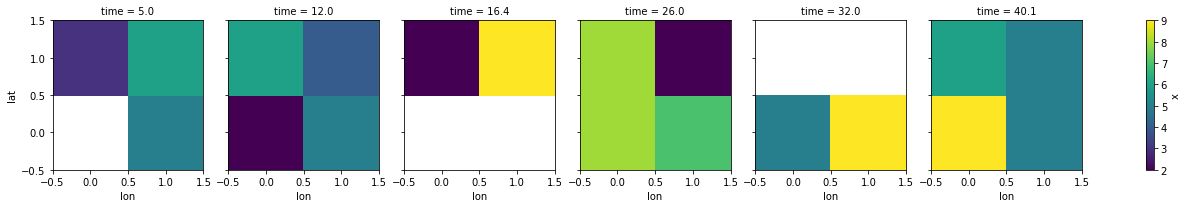

In [12]:
ds.x.plot(col='time');

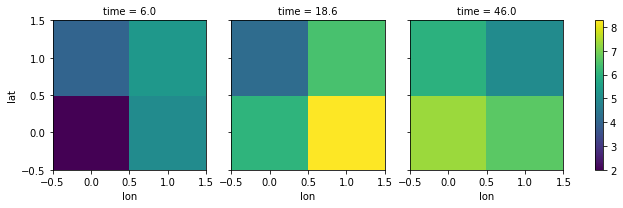

In [13]:
remapper(ds.x).plot(col='time');

In [14]:
ds.x

<xarray.DataArray 'x' (time: 6, lat: 2, lon: 2)>
array([[[nan,  5.],
        [ 3.,  6.]],

       [[ 2.,  5.],
        [ 6.,  4.]],

       [[nan, nan],
        [ 2.,  9.]],

       [[ 8.,  7.],
        [ 8.,  2.]],

       [[ 5.,  9.],
        [nan, nan]],

       [[ 9.,  5.],
        [ 6.,  5.]]], dtype=float32)
Coordinates:
  * time     (time) float64 5.0 12.0 16.4 26.0 32.0 40.1
Dimensions without coordinates: lat, lon

In [15]:
remapper(ds.x)

<xarray.DataArray (time: 3, lat: 2, lon: 2)>
array([[[2.        , 5.        ],
        [4.        , 5.33333333]],

       [[6.09090909, 8.27272727],
        [4.18181818, 6.45454545]],

       [[7.33333333, 6.66666667],
        [6.        , 5.        ]]])
Coordinates:
  * time     (time) float64 6.0 18.6 46.0
Dimensions without coordinates: lat, lon